In [163]:
# Dependency Check & Setup Instructions
import sys
import subprocess
from IPython.display import display, HTML

def check_and_install_package(package_name, import_name=None):
    """Check if package is installed, install if missing"""
    if import_name is None:
        import_name = package_name
    
    try:
        __import__(import_name)
        return True
    except ImportError:
        print(f"Installing {package_name}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        return True

# Check required packages
required_packages = [
    ("mlflow", "mlflow"),
    ("pandas", "pandas"), 
    ("numpy", "numpy"),
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("scikit-learn", "sklearn"),
    ("scipy", "scipy")
]

missing_packages = []
for package, import_name in required_packages:
    try:
        __import__(import_name)
    except ImportError:
        missing_packages.append(package)
        print(f"{package} - Missing")


# Training Report

### What This Notebook Shows

- **Training Progress** - Loss curves and convergence analysis from MLflow metrics
- **Label-wise Performance Metrics** - Detailed precision, recall, and F1 scores for each class
- **Visual Performance Charts** - Interactive plots showing model performance across all labels
- **Confusion Matrix Heatmap** - Visual representation of classification accuracy
- **ROC Curves** - Receiver Operating Characteristic analysis

---


In [164]:
# Setup & MLflow Connection
import mlflow
import logging
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
import pandas as pd, numpy as np, json, os, matplotlib.pyplot as plt, seaborn as sns
from IPython.display import display, HTML, Markdown
import warnings
warnings.filterwarnings('ignore')

import os
import os
os.environ['MLFLOW_ARTIFACT_DOWNLOAD_PROGRESS'] = 'false'
os.environ['MLFLOW_TRACKING_INSECURE_TLS'] = 'true'
os.environ['MLFLOW_DISABLE_ENV_CREATION'] = 'true'
import tqdm
tqdm.tqdm.disable = True
logging.getLogger("mlflow").setLevel(logging.ERROR)

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Set color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#7209B7', '#0FA3B1']
sns.set_palette(colors)

#print("Setting up MLflow connection...")
mlflow.set_tracking_uri("file:///workspaces/MultilabelPhotoTag_Pipeline_MKlas/mlruns")

EXPERIMENT_NAME = "photo-tagger-experiment"
#print(f"Looking for experiment: {EXPERIMENT_NAME}")

logging.getLogger("mlflow").setLevel(logging.ERROR)
client = MlflowClient()
exp = client.get_experiment_by_name(EXPERIMENT_NAME) or client.get_experiment_by_name("Default")

if exp is None:
    print("No experiment found!")
    raise RuntimeError(f"Experiment '{EXPERIMENT_NAME}' not found.")

runs = client.search_runs([exp.experiment_id], run_view_type=ViewType.ACTIVE_ONLY,
                          order_by=["attributes.start_time DESC"], max_results=1)
if not runs:
    print("No runs found in experiment!")
    raise RuntimeError(f"No runs in experiment {exp.name}.")

run = runs[0]
run_id = run.info.run_id

#print("Connection established!")
print(f"Analyzing Run ID: {run_id}")
print(f"Run Date: {pd.to_datetime(run.info.start_time, unit='ms').strftime('%Y-%m-%d %H:%M:%S')}")
if run.info.end_time is not None:
    duration_min = (run.info.end_time - run.info.start_time) / 1000 / 60
    print(f"Duration: {duration_min:.1f} minutes")
else:
    print("Duration: (run still in progress)")

# Display run metadata
run_params = run.data.params
run_metrics = run.data.metrics

# Check if evaluation artifacts exist
try:
    # Try to access evaluation summary to verify evaluate_last_run.py was executed
    eval_summary_path = client.download_artifacts(run_id, "evaluation_summary.json", ".")
    eval_summary = json.load(open(eval_summary_path))
    #print(f"Evaluation artifacts found (generated: {eval_summary.get('timestamp', 'unknown')})")
    evaluation_available = True
except Exception:
    print("No evaluation artifacts found. Please run 'evaluate_last_run.py' first!")
    evaluation_available = False

display(HTML(f"""
<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 20px; border-radius: 10px; margin: 10px 0;">
    <h3 style="margin: 0; text-align: center;">🏃‍♂️ Run Overview</h3>
    <div style="display: grid; grid-template-columns: 1fr 1fr 1fr; gap: 15px; margin-top: 15px;">
        <div style="text-align: center;">
            <strong>Model Architecture</strong><br>
            {run_params.get('backbone', 'N/A')}
        </div>
        <div style="text-align: center;">
            <strong>Training Epochs</strong><br>
            {run_params.get('train_epochs', 'N/A')}
        </div>
        <div style="text-align: center;">
            <strong>Batch Size</strong><br>
            {run_params.get('batch_size', 'N/A')}
        </div>
    </div>
</div>
"""))

Analyzing Run ID: 4cd46de433fc4b218b553f3ec576dbd1
Run Date: 2025-06-23 16:07:50
Duration: 114.7 minutes


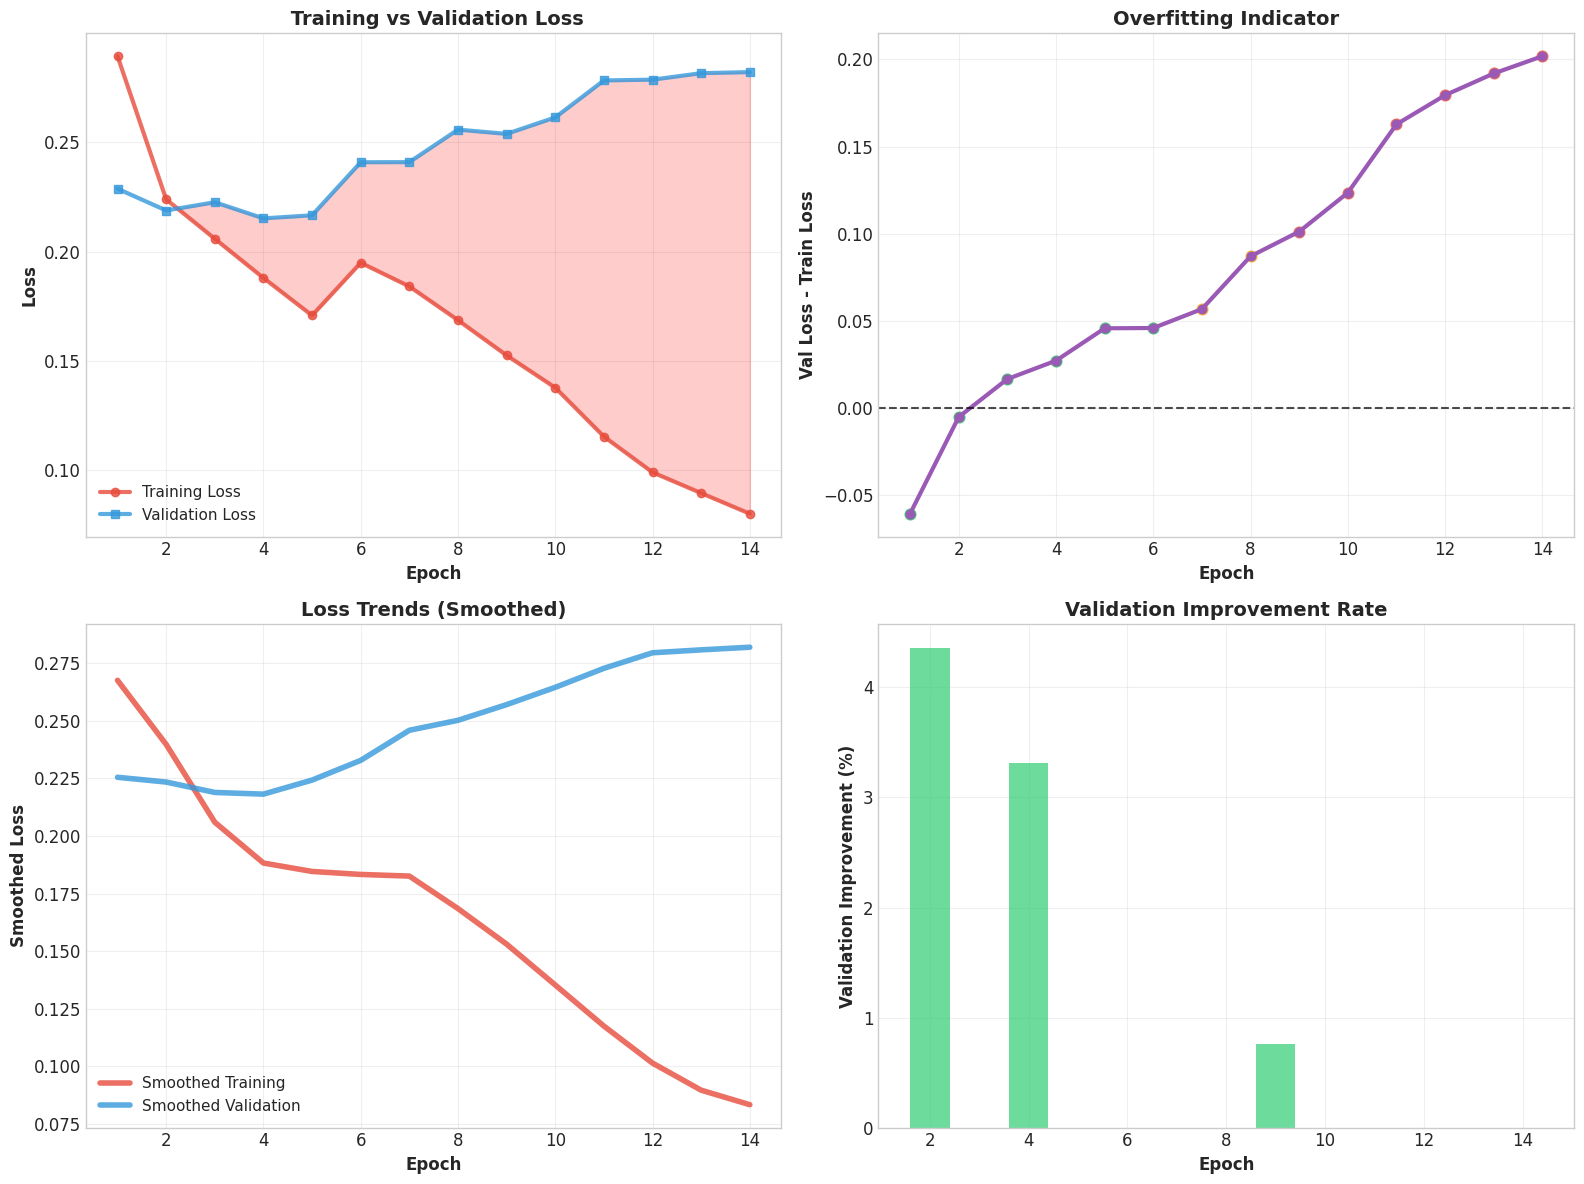

In [165]:
# ---------- Training Progress & Loss Analysis ----------
display(HTML("""
<div style="background: linear-gradient(135deg, #fa709a 0%, #fee140 100%); color: white; padding: 15px; border-radius: 8px; margin: 20px 0 5px 0;">
    <h3 style="margin: 0; text-align: center;">Training Progress Analysis</h3>
    <p style="margin: 5px 0 0 0; text-align: center; font-size: 14px;">Loss curves and convergence behavior from MLflow metrics</p>
</div>
"""))

# Load training history from MLflow metrics
try:
    # Get all metrics for this run
    all_metrics = client.get_metric_history(run_id, "train_loss")
    val_metrics = client.get_metric_history(run_id, "val_loss")
    
    if all_metrics and val_metrics:
        # Extract loss data from MLflow metrics
        train_losses = [m.value for m in all_metrics]
        val_losses = [m.value for m in val_metrics]
        epochs = [m.step for m in all_metrics]
        
        # Create comprehensive training analysis
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Main loss curves
        ax1.plot(epochs, train_losses, 'o-', linewidth=3, markersize=6, 
                label='Training Loss', color='#e74c3c', alpha=0.8)
        ax1.plot(epochs, val_losses, 's-', linewidth=3, markersize=6, 
                label='Validation Loss', color='#3498db', alpha=0.8)
        
        ax1.set_xlabel("Epoch", fontweight='bold')
        ax1.set_ylabel("Loss", fontweight='bold')
        ax1.set_title(" Training vs Validation Loss", fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        
        # Fill between for overfitting visualization
        ax1.fill_between(epochs, train_losses, val_losses, alpha=0.2, 
                        where=np.array(val_losses) > np.array(train_losses), 
                        color='red', interpolate=True, label='Potential Overfitting')
        
        # 2. Loss difference (overfitting indicator)
        loss_diff = np.array(val_losses) - np.array(train_losses)
        ax2.plot(epochs, loss_diff, 'o-', linewidth=3, markersize=6, color='#9b59b6')
        ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
        ax2.set_xlabel("Epoch", fontweight='bold')
        ax2.set_ylabel("Val Loss - Train Loss", fontweight='bold')
        ax2.set_title("Overfitting Indicator", fontsize=14, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        # Color coding for overfitting
        for i, diff in enumerate(loss_diff):
            color = '#e74c3c' if diff > 0.1 else '#f39c12' if diff > 0.05 else '#27ae60'
            ax2.scatter(epochs[i], diff, c=color, s=60, alpha=0.7)
        
        # 3. Loss smoothing (trend) 
        try:
            from scipy.ndimage import uniform_filter1d
            if len(train_losses) > 3:
                smooth_train = uniform_filter1d(train_losses, size=min(3, len(train_losses)))
                smooth_val = uniform_filter1d(val_losses, size=min(3, len(val_losses)))
                
                ax3.plot(epochs, smooth_train, linewidth=4, label='Smoothed Training', color='#e74c3c', alpha=0.8)
                ax3.plot(epochs, smooth_val, linewidth=4, label='Smoothed Validation', color='#3498db', alpha=0.8)
                ax3.set_xlabel("Epoch", fontweight='bold')
                ax3.set_ylabel("Smoothed Loss", fontweight='bold')
                ax3.set_title("Loss Trends (Smoothed)", fontsize=14, fontweight='bold')
                ax3.legend(fontsize=11)
                ax3.grid(True, alpha=0.3)
        except ImportError:
            # If scipy not available, show raw data
            ax3.plot(epochs, train_losses, linewidth=2, label='Training Loss', color='#e74c3c', alpha=0.8)
            ax3.plot(epochs, val_losses, linewidth=2, label='Validation Loss', color='#3498db', alpha=0.8)
            ax3.set_xlabel("Epoch", fontweight='bold')
            ax3.set_ylabel("Loss", fontweight='bold')
            ax3.set_title("Loss Trends", fontsize=14, fontweight='bold')
            ax3.legend(fontsize=11)
            ax3.grid(True, alpha=0.3)
        
        # 4. Training convergence analysis
        if len(val_losses) > 5:
            # Calculate improvement rate
            improvements = []
            for i in range(1, len(val_losses)):
                if val_losses[i] < val_losses[i-1]:
                    improvements.append((val_losses[i-1] - val_losses[i]) / val_losses[i-1] * 100)
                else:
                    improvements.append(0)
            
            ax4.bar(epochs[1:], improvements, color='#2ecc71', alpha=0.7)
            ax4.set_xlabel("Epoch", fontweight='bold')
            ax4.set_ylabel("Validation Improvement (%)", fontweight='bold')
            ax4.set_title("Validation Improvement Rate", fontsize=14, fontweight='bold')
            ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Training insights
        min_train_loss = min(train_losses)
        min_val_loss = min(val_losses)
        final_train_loss = train_losses[-1]
        final_val_loss = val_losses[-1]
        best_epoch = epochs[val_losses.index(min_val_loss)]
        
        # Calculate overfitting severity
        final_gap = final_val_loss - final_train_loss
        if final_gap > 0.2:
            overfitting_status = "High overfitting detected"
            overfitting_color = "#e74c3c"
        elif final_gap > 0.1:
            overfitting_status = "Moderate overfitting"
            overfitting_color = "#f39c12"
        else:
            overfitting_status = "Good generalization"
            overfitting_color = "#27ae60"
        
        display(HTML(f"""
        <div style="background: #f8f9fa; border-radius: 8px; padding: 20px; margin: 20px 0 5px 0;">
            <h4 style="color: #495057; margin: 0 0 15px 0;">Training Analysis Summary</h4>
            <div style="display: grid; grid-template-columns: 1fr 1fr 1fr; gap: 20px;">
                <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #3498db;">
                    <h5 style="margin: 0; color: #3498db;">Best Performance</h5>
                    <p style="margin: 5px 0;"><strong>Best Validation Loss:</strong> {min_val_loss:.4f}</p>
                    <p style="margin: 5px 0;"><strong>Best Epoch:</strong> {best_epoch}</p>
                </div>
                <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid #e74c3c;">
                    <h5 style="margin: 0; color: #e74c3c;">Final Performance</h5>
                    <p style="margin: 5px 0;"><strong>Final Train Loss:</strong> {final_train_loss:.4f}</p>
                    <p style="margin: 5px 0;"><strong>Final Val Loss:</strong> {final_val_loss:.4f}</p>
                </div>
                <div style="background: white; padding: 15px; border-radius: 8px; border-left: 4px solid {overfitting_color};">
                    <h5 style="margin: 0; color: {overfitting_color};">🔍 Generalization</h5>
                    <p style="margin: 5px 0;"><strong>Status:</strong> {overfitting_status}</p>
                    <p style="margin: 5px 0;"><strong>Loss Gap:</strong> {final_gap:.4f}</p>
                </div>
            </div>
        </div>
        """))
        
    else:
        display(HTML("""
        <div style="background: #fff3cd; border: 1px solid #ffc107; border-radius: 8px; padding: 15px; color: #856404;">
            <h4>Training History Not Available</h4>
            <p>No training/validation loss metrics found in MLflow for this run.</p>
            <p>Make sure your training script logs <code>train_loss</code> and <code>val_loss</code> metrics to MLflow during training.</p>
        </div>
        """))

except Exception as e:
    display(HTML(f"""
    <div style="background: #fff3cd; border: 1px solid #ffc107; border-radius: 8px; padding: 15px; color: #856404;">
        <h4>Training Progress Data Not Available</h4>
        <p>Could not load training progress data: {e}</p>
        <p>Ensure that training metrics are being logged to MLflow during model training.</p>
    </div>
    """))

In [166]:
# ---------- Label-wise Performance Analysis ----------
#print("Loading classification metrics...")

if not evaluation_available:
    display(HTML("""
    <div style="background: #fff3cd; border: 1px solid #ffc107; border-radius: 8px; padding: 15px; color: #856404;">
        <h4>Evaluation Required</h4>
        <p>Please run <code>python scripts/evaluate_last_run.py</code> first to generate evaluation artifacts.</p>
        <p>This script will create the classification report and other visualizations that this notebook displays.</p>
    </div>
    """))
else:
    try:
        # Load classification report from artifacts
        report_path = client.download_artifacts(run_id, "classification_report.json", ".")
        report = json.load(open(report_path))
        
        # Create comprehensive metrics DataFrame
        metrics_df = pd.DataFrame(report).T
        metrics_df.index.name = "Label"
        
        # Get label names (excluding summary metrics)
        label_names = [idx for idx in metrics_df.index if idx not in ['accuracy', 'macro avg', 'micro avg', 'weighted avg']]
        
        # Display title
        display(HTML("""
        <div style="background: linear-gradient(135deg, #11998e 0%, #38ef7d 100%); color: white; padding: 15px; border-radius: 8px; margin: 20px 0 0px 0;">
            <h3 style="margin: 0; text-align: center;">Per-Label Performance Metrics</h3>
            <p style="margin: 5px 0 0 0; text-align: center; font-size: 14px;">Detailed breakdown of model performance for each class</p>
        </div>
        """))
        
        # Create individual label performance cards
        if label_names:
            # Sort labels by F1-score for better visualization
            label_performance = [(label, metrics_df.loc[label, 'f1-score']) for label in label_names if label in metrics_df.index]
            label_performance.sort(key=lambda x: x[1], reverse=True)
            
            # Display performance cards
            cards_html = '<div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(300px, 1fr)); gap: 15px; margin: 20px 0 0px 0;">'
            
            for i, (label, f1_score) in enumerate(label_performance):
                if label in metrics_df.index:
                    precision = metrics_df.loc[label, 'precision']
                    recall = metrics_df.loc[label, 'recall']
                    support = int(metrics_df.loc[label, 'support'])
                    
                    # Color based on performance
                    if f1_score >= 0.8:
                        color = "#28a745"  # Green
                    elif f1_score >= 0.6:
                        color = "#ffc107"  # Yellow
                    else:
                        color = "#dc3545"  # Red
                    
                    cards_html += f"""
                    <div style="background: white; border-left: 5px solid {color}; padding: 15px; border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);">
                        <h4 style="margin: 0 0 10px 0; color: {color};">{label.upper()}</h4>
                        <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 10px;">
                            <div><strong>Precision:</strong> {precision:.3f}</div>
                            <div><strong>Recall:</strong> {recall:.3f}</div>
                            <div><strong>F1-Score:</strong> {f1_score:.3f}</div>
                            <div><strong>Support:</strong> {support}</div>
                        </div>
                        <div style="background: #f8f9fa; padding: 8px; border-radius: 4px; margin-top: 10px;">
                            <div style="background: {color}; height: 8px; width: {f1_score*100}%; border-radius: 4px;"></div>
                            <small style="color: #666;">Performance: {f1_score:.1%}</small>
                        </div>
                    </div>
                    """
            
            cards_html += '</div>'
            display(HTML(cards_html))
        
        # Summary metrics table
        display(HTML("""
        <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 15px; border-radius: 8px; margin: 20px 0 5px 0;">
            <h3 style="margin: 0; text-align: center;">Overall Performance Summary</h3>
        </div>
        """))
        
        # Display summary metrics
        summary_metrics = ['accuracy', 'macro avg', 'micro avg', 'weighted avg']
        summary_df = metrics_df.loc[[m for m in summary_metrics if m in metrics_df.index]]
        
        # Style the summary table
        styled_summary = summary_df.style.background_gradient(cmap='RdYlGn', subset=['precision', 'recall', 'f1-score']) \
                                        .format({'precision': '{:.3f}', 'recall': '{:.3f}', 'f1-score': '{:.3f}', 'support': '{:.0f}'}) \
                                        .set_table_styles([
                                            {'selector': 'th', 'props': [('background-color', '#f8f9fa'), ('font-weight', 'bold')]},
                                            {'selector': 'td', 'props': [('text-align', 'center')]},
                                            {'selector': '', 'props': [('border-collapse', 'collapse'), ('margin', '0 auto')]}
                                        ])
        
        #display(styled_summary)
        
        # Performance insights
        if label_names:
            best_label = max(label_performance, key=lambda x: x[1])
            worst_label = min(label_performance, key=lambda x: x[1])
            
            insights_html = f"""
            <div style="background: #e3f2fd; border: 1px solid #2196f3; border-radius: 8px; padding: 15px; margin: 20px 0 5px 0;">
                <h4 style="color: #1976d2; margin: 0 0 10px 0;">Key Insights</h4>
                <ul style="margin: 0; padding-left: 20px;">
                    <li><strong>Best performing class:</strong> {best_label[0]} (F1: {best_label[1]:.3f})</li>
                    <li><strong>Needs improvement:</strong> {worst_label[0]} (F1: {worst_label[1]:.3f})</li>
                    <li><strong>Average F1-score:</strong> {np.mean([x[1] for x in label_performance]):.3f}</li>
                    <li><strong>Performance range:</strong> {best_label[1] - worst_label[1]:.3f} (lower is better)</li>
                </ul>
            </div>
            """
            display(HTML(insights_html))

    except Exception as e:
        display(HTML(f"""
        <div style="background: #ffebee; border: 1px solid #f44336; border-radius: 8px; padding: 15px; color: #c62828;">
            <h4>Classification Report Error</h4>
            <p>Could not load classification metrics: {e}</p>
            <p>Make sure <code>evaluate_last_run.py</code> completed successfully.</p>
        </div>
        """))

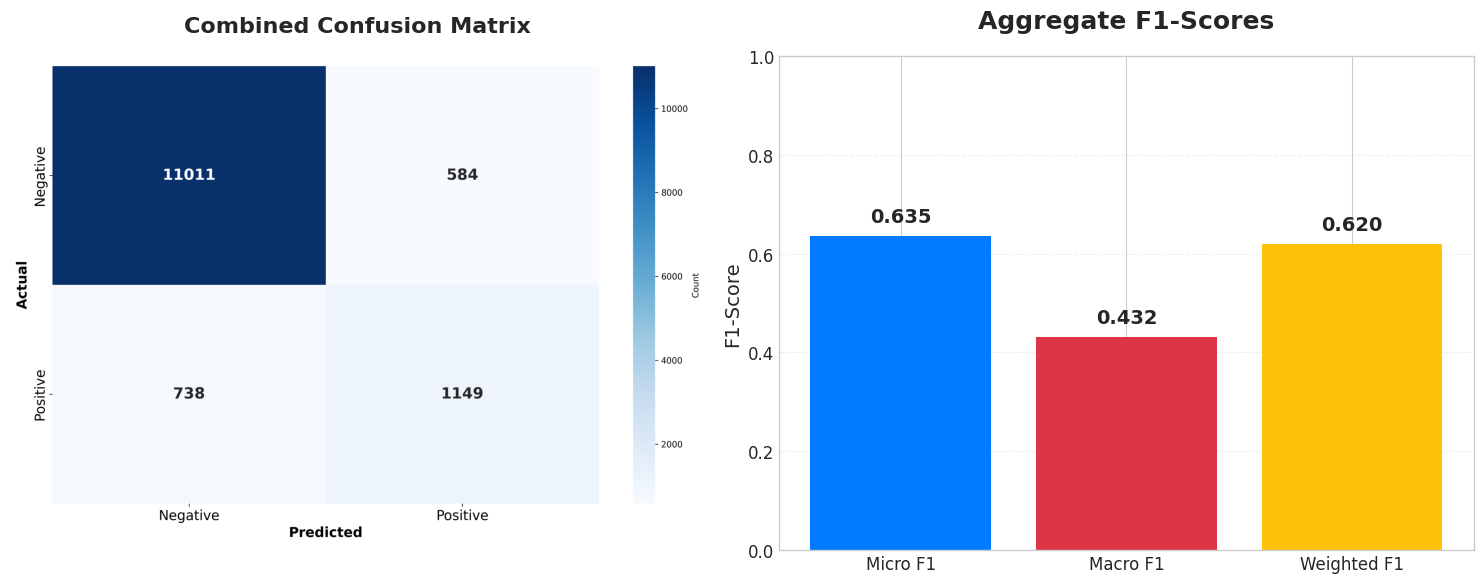

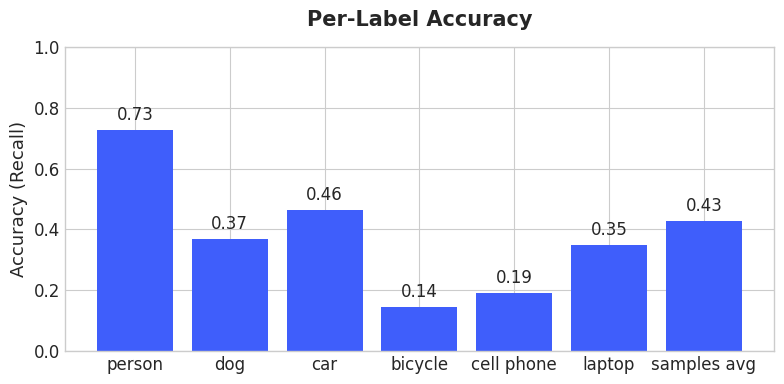

Class,Precision,Recall,F1-Score,Support
Person,0.711,0.727,0.719,1297
Dog,0.608,0.369,0.459,84
Car,0.487,0.464,0.476,252
Bicycle,0.588,0.145,0.233,69
Cell Phone,0.351,0.190,0.247,105
Laptop,0.667,0.350,0.459,80
Samples Avg,0.452,0.429,0.430,1887


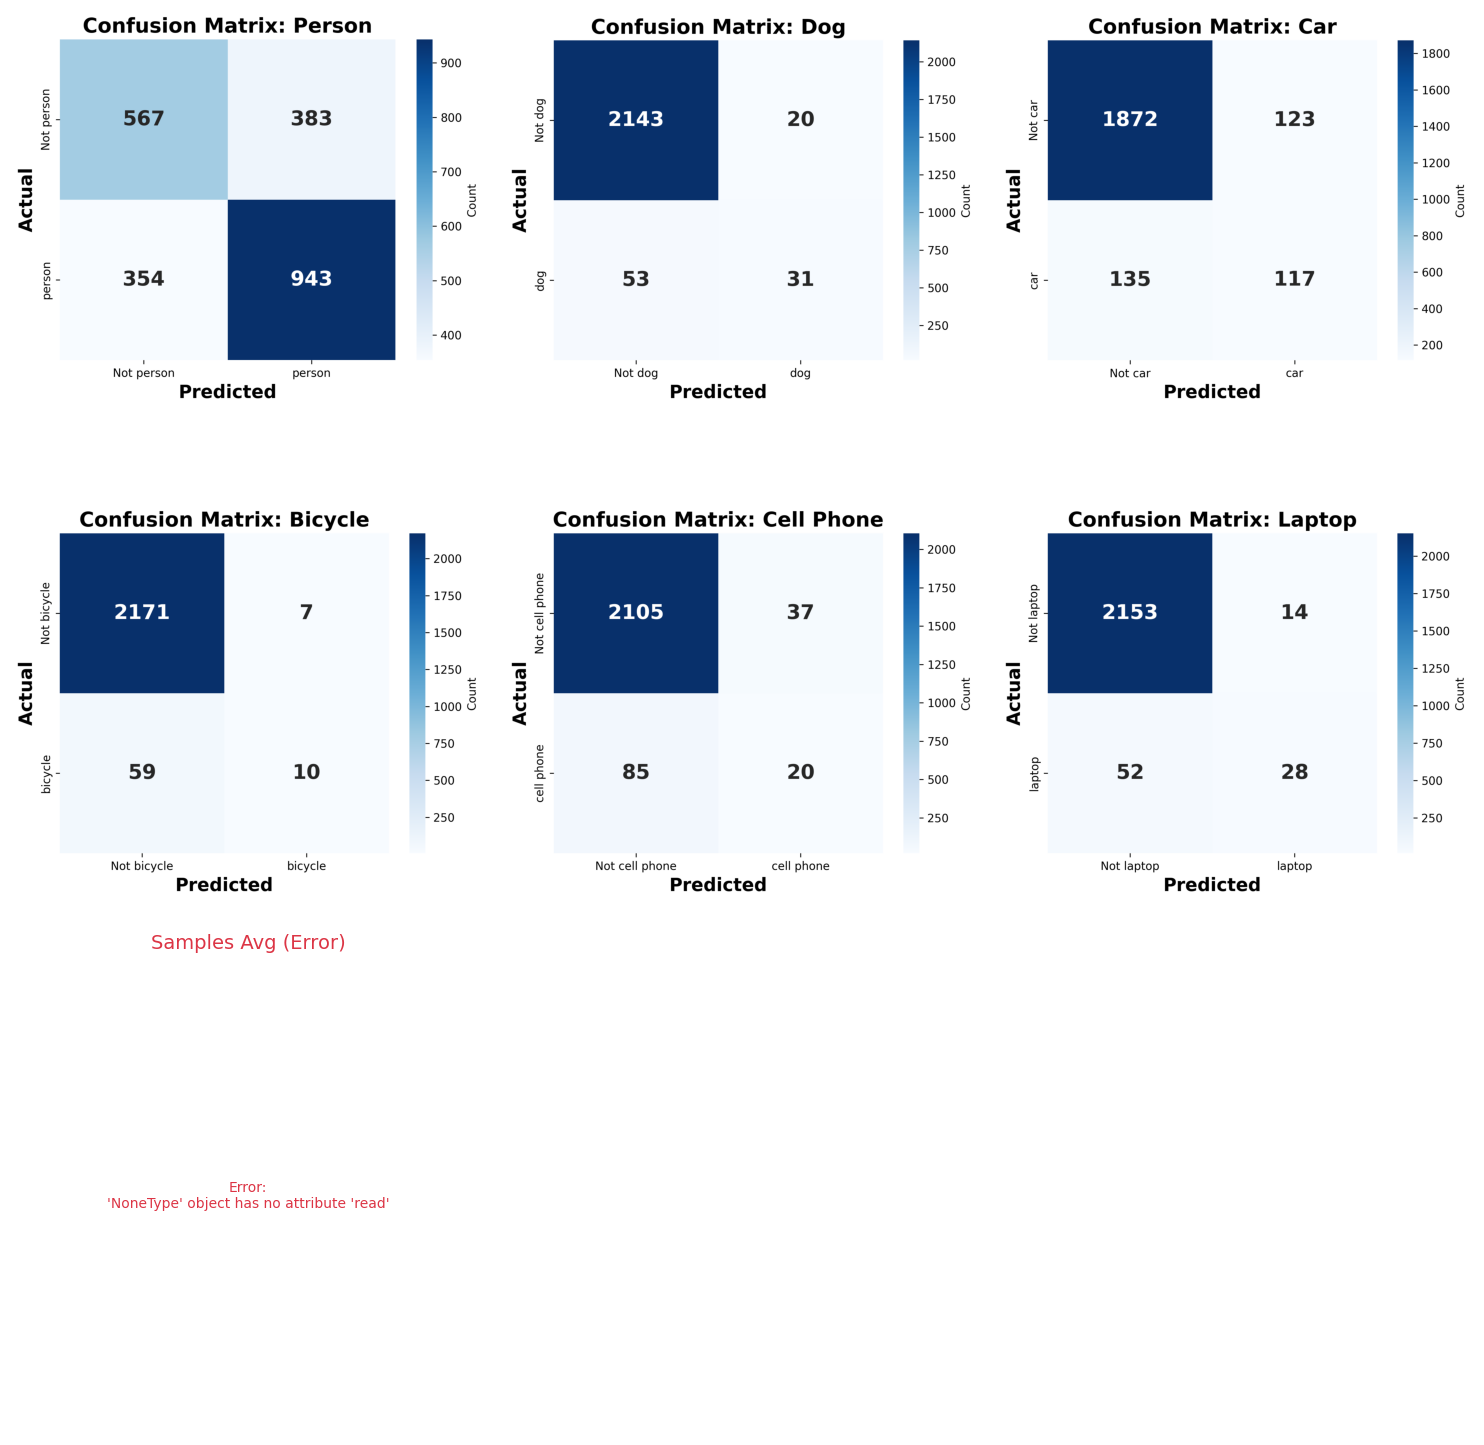

In [167]:
# ---------- Enhanced Confusion Matrix Analysis ----------
display(HTML("""
<div style="background: linear-gradient(135deg, #fc466b 0%, #3f5efb 100%); color: white; padding: 15px; border-radius: 8px; margin: 20px 0 5px 0;">
    <h3 style="margin: 0; text-align: center;"> Confusion Matrix Heatmap</h3>
    <p style="margin: 5px 0 0 0; text-align: center; font-size: 14px;">Visual representation of classification accuracy</p>
</div>
"""))

if not evaluation_available:
    display(HTML("""
    <div style="background: #fff3cd; border: 1px solid #ffc107; border-radius: 8px; padding: 15px; color: #856404;">
        <h4>Evaluation Required</h4>
        <p>Please run <code>python scripts/evaluate_last_run.py</code> first to generate confusion matrix visualizations.</p>
    </div>
    """))
else:
    try:
        # Download the combined confusion matrix from artifacts
        cm_path = client.download_artifacts(run_id, "confusion_matrix.png", ".")
        
        # Create a subplot with the confusion matrix and additional analysis
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Display the confusion matrix image
        img = plt.imread(cm_path)
        ax1.imshow(img)
        ax1.axis("off")
        ax1.set_title("Combined Confusion Matrix", fontsize=16, fontweight='bold', pad=20)
        
        # Multilabel accuracy analysis: show micro/macro/weighted F1-scores as a bar chart
        if 'report' in locals():
            # Extract summary metrics for bar chart
            summary_metrics = ['micro avg', 'macro avg', 'weighted avg']
            f1_scores = [report[m]['f1-score'] for m in summary_metrics]
            colors = ['#007bff', '#dc3545', '#ffc107']
            labels = ['Micro F1', 'Macro F1', 'Weighted F1']

            ax2.bar(labels, f1_scores, color=colors)
            for i, v in enumerate(f1_scores):
                ax2.text(i, v + 0.02, f"{v:.3f}", ha='center', va='bottom', fontsize=14, fontweight='bold')
                ax2.set_ylim(0, 1)
                ax2.set_ylabel("F1-Score", fontsize=14)
                ax2.set_title("Aggregate F1-Scores", fontsize=18, fontweight='bold', pad=20)
                ax2.grid(axis='y', linestyle='--', alpha=0.3)

        plt.tight_layout()
        plt.show()
        # Compute and display per-label accuracy as a bar plot
        if 'metrics_df' in locals() and 'label_names' in locals():
            # Per-label accuracy: TP+TN / Total, but for multilabel, use recall as proxy for per-class accuracy
            per_label_accuracy = metrics_df.loc[label_names, 'recall'].values
            fig_acc, ax_acc = plt.subplots(figsize=(8, 4))
            bars = ax_acc.bar(label_names, per_label_accuracy, color='#3f5efb')
            ax_acc.set_ylim(0, 1)
            ax_acc.set_ylabel("Accuracy (Recall)", fontsize=13)
            ax_acc.set_title("Per-Label Accuracy", fontsize=15, fontweight='bold', pad=15)
            for i, v in enumerate(per_label_accuracy):
                ax_acc.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom', fontsize=12)
            plt.tight_layout()
            plt.show()
        # Performance summary table
        if 'report' in locals() and 'label_names' in locals():
            display(HTML("""
            <div style="background: #f8f9fa; border-radius: 8px; padding: 15px; margin: 15px 0;">
                <h4 style="color: #495057; margin: 0 0 15px 0;">Classification Summary</h4>
            """))
            
            # Create performance summary
            perf_data = []
            for label in label_names:
                if label in metrics_df.index:
                    perf_data.append({
                        'Class': label.title(),
                        'Precision': f"{metrics_df.loc[label, 'precision']:.3f}",
                        'Recall': f"{metrics_df.loc[label, 'recall']:.3f}",
                        'F1-Score': f"{metrics_df.loc[label, 'f1-score']:.3f}",
                        'Support': int(metrics_df.loc[label, 'support'])
                    })
            
            perf_summary_df = pd.DataFrame(perf_data)
            # Display the performance summary DataFrame as an HTML table with custom styling
            display(HTML(
                perf_summary_df.style
                    .hide(axis="index")
                    .set_table_styles([
                        {'selector': 'th', 'props': [('background-color', "#dddddd"), ('color', '#212529'), ('font-weight', 'bold'), ('font-size', '14px')]},
                        {'selector': 'td', 'props': [('font-size', '13px'), ('padding', '6px 12px')]},
                        {'selector': 'tr:nth-child(even)', 'props': [('background-color', '#f8f9fa')]},
                        {'selector': 'tr:hover', 'props': [('background-color', '#e9ecef')]}
                    ])
                    .set_properties(**{'text-align': 'center'})
                    .to_html()
            ))
            
            #display(HTML("</div>"))
                       
        # Show individual class confusion matrices info
        # Show all individual class confusion matrices as default
        if 'label_names' in locals():
            display(HTML(f"""
            <div style="background: #e8f5e8; border: 1px solid #28a745; border-radius: 8px; padding: 15px; margin: 20px 0 5px 0;">
            <h4 style="color: #155724; margin: 0 0 10px 0;">Individual Class Confusion Matrices</h4>
            <p style="margin: 0; font-size: 14px;">
            Below are the confusion matrices for each of the {len(label_names)} classes, shown together for comparison.
            </p>
            </div>
            """))
            # Filter out 'samples avg' from label_names if present
            filtered_labels = [lbl for lbl in label_names if lbl.lower() != 'samples avr']
            n_classes = len(label_names)
            n_cols = min(n_classes, 3)
            n_rows = (n_classes + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
            axes = axes.flatten() if n_classes > 1 else [axes]
            for idx, label in enumerate(label_names):
                ax = axes[idx]
                try:
                    class_cm_path = client.download_artifacts(run_id, f"confusion_matrix_{label}.png", ".")
                    img = plt.imread(class_cm_path)
                    ax.imshow(img)
                    ax.axis("off")
                    #ax.set_title(f"{label.title()}", fontsize=14)
                except Exception as e:
                    ax.axis("off")
                    ax.set_title(f"{label.title()} (Error)", fontsize=14, color="#dc3545")
                    ax.text(0.5, 0.5, f"Error:\n{e}", ha='center', va='center', color="#dc3545", fontsize=10)
            # Hide any unused subplots
            for j in range(idx + 1, len(axes)):
                axes[j].axis("off")
            plt.tight_layout()
            plt.show()

    except Exception as e:
        display(HTML(f"""
        <div style="background: #fff3cd; border: 1px solid #ffc107; border-radius: 8px; padding: 15px; color: #856404;">
            <h4>Confusion Matrix Not Available</h4>
            <p>Could not load confusion matrix visualization: {e}</p>
            <p>Make sure <code>evaluate_last_run.py</code> completed successfully and generated the confusion matrix artifacts.</p>
        </div>
        """))

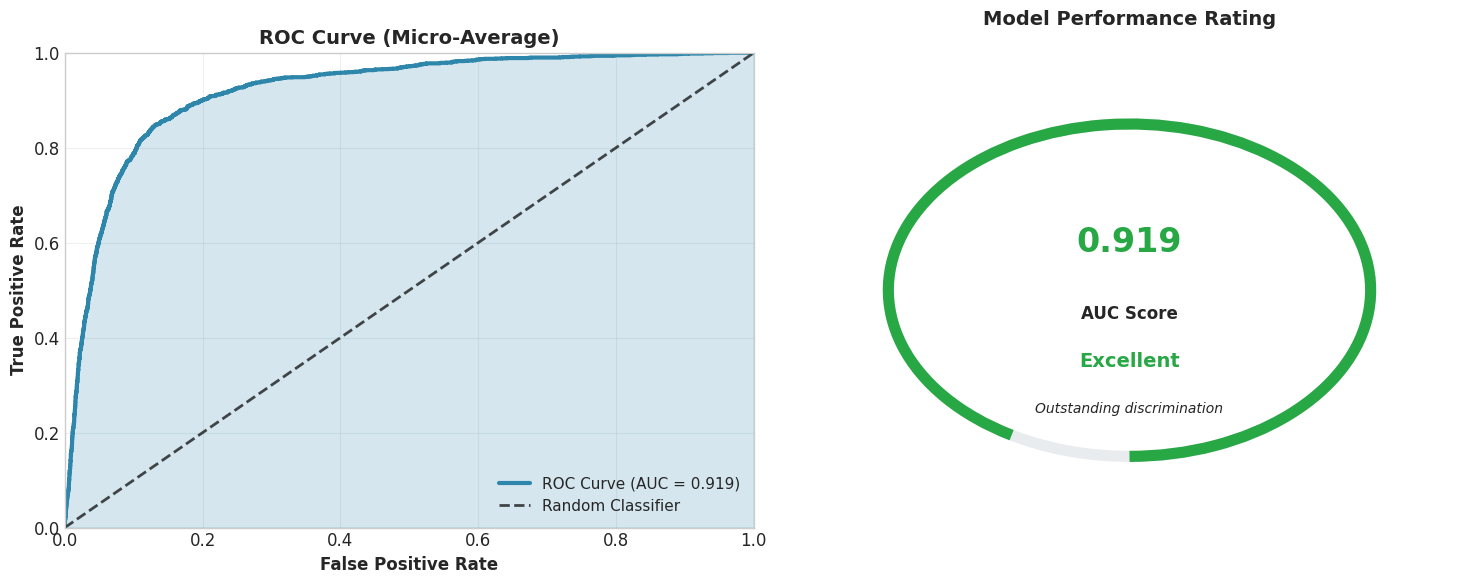

In [168]:
# ---------- Enhanced ROC Curve Analysis ----------
display(HTML("""
<div style="background: linear-gradient(135deg, #36d1dc 0%, #5b86e5 100%); color: white; padding: 15px; border-radius: 8px; margin: 20px 0 5px 0;">
    <h3 style="margin: 0; text-align: center;">ROC Curve Analysis</h3>
    <p style="margin: 5px 0 0 0; text-align: center; font-size: 14px;">Receiver Operating Characteristic - Model Discrimination Power</p>
</div>
"""))

if not evaluation_available:
    display(HTML("""
    <div style="background: #fff3cd; border: 1px solid #ffc107; border-radius: 8px; padding: 15px; color: #856404;">
        <h4>Evaluation Required</h4>
        <p>Please run <code>python scripts/evaluate_last_run.py</code> first to generate ROC curve data.</p>
    </div>
    """))
else:
    try:
        # Load ROC curve data from artifacts
        roc_path = client.download_artifacts(run_id, "roc_curve.json", ".")
        roc_data = json.load(open(roc_path))
        fpr, tpr = np.array(roc_data["fpr"]), np.array(roc_data["tpr"])
        auc_score = roc_data.get("auc", np.trapz(tpr, fpr))  # Use stored AUC or calculate
        
        # Create enhanced ROC visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Main ROC curve
        ax1.plot(fpr, tpr, linewidth=3, label=f"ROC Curve (AUC = {auc_score:.3f})", color='#2E86AB')
        ax1.plot([0,1], [0,1], 'k--', linewidth=2, label="Random Classifier", alpha=0.7)
        ax1.fill_between(fpr, tpr, alpha=0.2, color='#2E86AB')
        
        ax1.set_xlabel("False Positive Rate", fontsize=12, fontweight='bold')
        ax1.set_ylabel("True Positive Rate", fontsize=12, fontweight='bold')
        ax1.set_title("ROC Curve (Micro-Average)", fontsize=14, fontweight='bold')
        ax1.legend(fontsize=11)
        ax1.grid(True, alpha=0.3)
        ax1.set_xlim([0, 1])
        ax1.set_ylim([0, 1])
        
        # AUC interpretation gauge
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        
        # Create AUC interpretation
        if auc_score >= 0.9:
            performance = "Excellent"
            color = "#28a745"
            interpretation = "Outstanding discrimination"
        elif auc_score >= 0.8:
            performance = "Good"
            color = "#17a2b8"
            interpretation = "Good discrimination"
        elif auc_score >= 0.7:
            performance = "Fair"
            color = "#ffc107"
            interpretation = "Fair discrimination"
        elif auc_score >= 0.6:
            performance = "Poor"
            color = "#fd7e14"
            interpretation = "Poor discrimination"
        else:
            performance = "Fail"
            color = "#dc3545"
            interpretation = "No discrimination"
        
        # Draw AUC gauge
        import matplotlib.patches as patches
        
        # Background circle
        circle = patches.Circle((0.5, 0.5), 0.35, linewidth=8, edgecolor='#e9ecef', facecolor='none')
        ax2.add_patch(circle)
        
        # Performance arc
        theta = auc_score * 2 * np.pi - np.pi/2  # Start from top
        arc = patches.Arc((0.5, 0.5), 0.7, 0.7, angle=0, theta1=-90, theta2=theta*180/np.pi, linewidth=8, color=color)
        ax2.add_patch(arc)
        
        # Center text
        ax2.text(0.5, 0.6, f'{auc_score:.3f}', ha='center', va='center', fontsize=24, fontweight='bold', color=color)
        ax2.text(0.5, 0.45, 'AUC Score', ha='center', va='center', fontsize=12, fontweight='bold')
        ax2.text(0.5, 0.35, performance, ha='center', va='center', fontsize=14, fontweight='bold', color=color)
        ax2.text(0.5, 0.25, interpretation, ha='center', va='center', fontsize=10, style='italic')
        
        ax2.set_title("Model Performance Rating", fontsize=14, fontweight='bold', pad=20)
        
        plt.tight_layout()
        plt.show()
        
        # Performance interpretation
        display(HTML(f"""
        <div style="background: {color}; color: white; border-radius: 8px; padding: 15px; margin: 15px 0;">
            <h4 style="margin: 0 0 10px 0;">AUC Score Interpretation</h4>
            <div style="display: grid; grid-template-columns: 1fr 2fr; gap: 15px; align-items: center;">
                <div style="text-align: center;">
                    <div style="font-size: 2em; font-weight: bold;">{auc_score:.3f}</div>
                    <div style="font-size: 1.2em;">{performance}</div>
                </div>
                <div>
                    <p style="margin: 0; font-size: 14px;"><strong>Performance Level:</strong> {interpretation}</p>
                    <p style="margin: 5px 0 0 0; font-size: 12px;">
                        AUC scores range from 0.5 (random) to 1.0 (perfect). Your model shows <strong>{performance.lower()}</strong> 
                        ability to distinguish between positive and negative classes.
                    </p>
                </div>
            </div>
        </div>
        """))

    except Exception as e:
        display(HTML(f"""
        <div style="background: #fff3cd; border: 1px solid #ffc107; border-radius: 8px; padding: 15px; color: #856404;">
            <h4>ROC Curve Not Available</h4>
            <p>Could not load ROC curve data: {e}</p>
            <p>Make sure <code>evaluate_last_run.py</code> completed successfully and generated the ROC curve artifacts.</p>
        </div>
        """))

In [169]:
# ---------- Comprehensive Performance Dashboard ----------
display(HTML("""
<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 15px; border-radius: 8px; margin: 20px 0 5px 0;">
    <h3 style="margin: 0; text-align: center;">Model Performance Dashboard</h3>
    <p style="margin: 5px 0 0 0; text-align: center; font-size: 14px;">Complete overview of model capabilities and recommendations</p>
</div>
"""))

if not evaluation_available:
    display(HTML("""
    <div style="background: #fff3cd; border: 1px solid #ffc107; border-radius: 8px; padding: 15px; color: #856404;">
        <h4>Evaluation Required</h4>
        <p>Please run <code>python scripts/evaluate_last_run.py</code> first to generate comprehensive evaluation metrics.</p>
    </div>
    """))
elif 'report' in locals() and 'metrics_df' in locals():
    # Define label_names as all class labels (not averages)
    label_names = [label for label in metrics_df.index if isinstance(label, (str, int)) and not str(label).endswith('avg') and not str(label).startswith('micro') and not str(label).startswith('weighted') and not str(label).startswith('samples')]
    
    # Extract key metrics
    accuracy = report.get('accuracy', 0)
    macro_avg = report.get('macro avg', {})
    micro_avg = report.get('micro avg', {})
    weighted_avg = report.get('weighted avg', {})
    
    # Create performance summary cards
    cards_html = """
    <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(250px, 1fr)); gap: 15px; margin: 20px 0;">
    """
    
    # Overall Accuracy Card
    accuracy_color = "#28a745" if accuracy > 0.8 else "#ffc107" if accuracy > 0.6 else "#dc3545"
    cards_html += f"""
    <div style="background: white; border-left: 5px solid {accuracy_color}; padding: 20px; border-radius: 8px; box-shadow: 0 4px 12px rgba(0,0,0,0.1);">
        <h4 style="margin: 0 0 10px 0; color: {accuracy_color};">Overall Accuracy</h4>
        <div style="font-size: 2.5em; font-weight: bold; color: {accuracy_color}; margin: 10px 0;">{accuracy:.1%}</div>
        <div style="background: #f8f9fa; height: 8px; border-radius: 4px;">
            <div style="background: {accuracy_color}; height: 8px; width: {accuracy*100}%; border-radius: 4px;"></div>
        </div>
    </div>
    """
    
    # Macro Average Card
    macro_f1 = macro_avg.get('f1-score', 0)
    macro_color = "#28a745" if macro_f1 > 0.8 else "#ffc107" if macro_f1 > 0.6 else "#dc3545"
    cards_html += f"""
    <div style="background: white; border-left: 5px solid {macro_color}; padding: 20px; border-radius: 8px; box-shadow: 0 4px 12px rgba(0,0,0,0.1);">
        <h4 style="margin: 0 0 10px 0; color: {macro_color};">Macro F1-Score</h4>
        <div style="font-size: 2.5em; font-weight: bold; color: {macro_color}; margin: 10px 0;">{macro_f1:.3f}</div>
        <div style="font-size: 12px; color: #666;">Average across all classes</div>
        <div style="background: #f8f9fa; height: 8px; border-radius: 4px; margin-top: 8px;">
            <div style="background: {macro_color}; height: 8px; width: {macro_f1*100}%; border-radius: 4px;"></div>
        </div>
    </div>
    """
    
    # Weighted Average Card
    weighted_f1 = weighted_avg.get('f1-score', 0)
    weighted_color = "#28a745" if weighted_f1 > 0.8 else "#ffc107" if weighted_f1 > 0.6 else "#dc3545"
    cards_html += f"""
    <div style="background: white; border-left: 5px solid {weighted_color}; padding: 20px; border-radius: 8px; box-shadow: 0 4px 12px rgba(0,0,0,0.1);">
        <h4 style="margin: 0 0 10px 0; color: {weighted_color};">⚖️ Weighted F1-Score</h4>
        <div style="font-size: 2.5em; font-weight: bold; color: {weighted_color}; margin: 10px 0;">{weighted_f1:.3f}</div>
        <div style="font-size: 12px; color: #666;">Support-weighted average</div>
        <div style="background: #f8f9fa; height: 8px; border-radius: 4px; margin-top: 8px;">
            <div style="background: {weighted_color}; height: 8px; width: {weighted_f1*100}%; border-radius: 4px;"></div>
        </div>
    </div>
    """
    
    # AUC Score Card (if available)
    if 'auc_score' in locals():
        auc_color = "#28a745" if auc_score > 0.8 else "#ffc107" if auc_score > 0.6 else "#dc3545"
        cards_html += f"""
        <div style="background: white; border-left: 5px solid {auc_color}; padding: 20px; border-radius: 8px; box-shadow: 0 4px 12px rgba(0,0,0,0.1);">
            <h4 style="margin: 0 0 10px 0; color: {auc_color};">AUC Score</h4>
            <div style="font-size: 2.5em; font-weight: bold; color: {auc_color}; margin: 10px 0;">{auc_score:.3f}</div>
            <div style="font-size: 12px; color: #666;">Discrimination ability</div>
            <div style="background: #f8f9fa; height: 8px; border-radius: 4px; margin-top: 8px;">
                <div style="background: {auc_color}; height: 8px; width: {auc_score*100}%; border-radius: 4px;"></div>
            </div>
        </div>
        """
    
    cards_html += "</div>"
    display(HTML(cards_html))
    
    # Performance recommendations
    recommendations = []
    
    if accuracy < 0.7:
        recommendations.append("Consider data augmentation or increasing model complexity")
    if macro_f1 < weighted_f1 - 0.1:
        recommendations.append("⚖️ Address class imbalance - some classes may be underperforming")
    if label_names and len(label_names) > 1:
        worst_f1 = min([metrics_df.loc[label, 'f1-score'] for label in label_names if label in metrics_df.index])
        if worst_f1 < 0.5:
            recommendations.append("Focus on improving poorly performing classes with targeted training")
    if 'auc_score' in locals() and auc_score < 0.8:
        recommendations.append("Consider feature engineering or different model architecture")
    
    if not recommendations:
        recommendations.append("Model performance looks good! Consider fine-tuning for marginal improvements")

else:
    display(HTML("""
    <div style="background: #fff3cd; border: 1px solid #ffc107; border-radius: 8px; padding: 15px; color: #856404;">
        <h4>Performance Data Not Available</h4>
        <p>Could not load performance metrics for dashboard creation.</p>
        <p>Ensure <code>evaluate_last_run.py</code> has been executed successfully.</p>
    </div>
    """))

In [170]:
import os
from IPython.display import HTML
from IPython import get_ipython
from datetime import datetime

# ---------- Export Report & Summary ----------
display(HTML("""
<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); color: white; padding: 15px; border-radius: 8px; margin: 20px 0;">
    <h3 style="margin: 0; text-align: center;">Export Complete Report</h3>
    <p style="margin: 5px 0 0 0; text-align: center; font-size: 14px;">Generate HTML export for sharing and documentation</p>
</div>
"""))

# Generate comprehensive report summary
report_summary = f"""
## Multi-Label Photo Tagger - Training Report Summary
**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Run ID:** {run_id}
**Experiment:** {EXPERIMENT_NAME}

### Pipeline Integration
This report was generated using the integrated evaluation pipeline:
1. **evaluate_last_run.py** - Generated evaluation artifacts and metrics
2. **run_report.ipynb** - Visualized the artifacts for analysis

### Key Performance Metrics
"""

if evaluation_available and 'report' in locals():
    accuracy = report.get('accuracy', 0)
    macro_f1 = report.get('macro avg', {}).get('f1-score', 0)
    weighted_f1 = report.get('weighted avg', {}).get('f1-score', 0)
    
    report_summary += f"""
- **Overall Accuracy:** {accuracy:.1%}
- **Macro F1-Score:** {macro_f1:.3f}
- **Weighted F1-Score:** {weighted_f1:.3f}
"""
    
    if 'auc_score' in locals():
        report_summary += f"- **AUC Score:** {auc_score:.3f}\n"

    if 'label_names' in locals() and label_names:
        report_summary += f"\n### Classes Analyzed ({len(label_names)} total)\n"
        for i, label in enumerate(label_names[:6]):  # Show first 6 classes
            if label in metrics_df.index:
                f1 = metrics_df.loc[label, 'f1-score']
                report_summary += f"- **{label.title()}:** F1 = {f1:.3f}\n"
        
        if len(label_names) > 6:
            report_summary += f"- *...and {len(label_names) - 6} more classes*\n"
else:
    report_summary += """
**Evaluation artifacts not available.**
Please run `python scripts/evaluate_last_run.py` to generate evaluation metrics.
"""

# Display summary
display(Markdown(report_summary))

if evaluation_available:
    # Export functionality
    try:
        # Get current notebook name
        try:
            notebook_path = get_ipython().kernel.shell.user_ns.get("__vsc_ipynb_file__", "")
            if not notebook_path:
                notebook_path = get_ipython().kernel.shell.user_ns.get("__notebook_source__", "")
            notebook_name = os.path.basename(notebook_path) if notebook_path else "run_report.ipynb"
        except Exception:
            notebook_name = "run_report.ipynb"

        # Ensure the assets directory exists
        assets_dir = "../assets"
        os.makedirs(assets_dir, exist_ok=True)

        # Generate timestamped filename
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        base_name = os.path.splitext(os.path.basename(notebook_name))[0]
        output_html = os.path.join(assets_dir, f"{base_name}_export_{timestamp}.html")

        # Export notebook to HTML
        export_command = f'jupyter nbconvert --to html --TagRemovePreprocessor.remove_cell_tags=\'{{"remove"}}\' --TagRemovePreprocessor.enabled=True --no-input --output "{output_html}" "{notebook_name}"'
        result = os.system(export_command)

        if result == 0:
            # Success message with file info
            file_size = os.path.getsize(output_html) / 1024  # Size in KB
            
            display(HTML(f"""
            <div style="background: linear-gradient(135deg, #28a745 0%, #20c997 100%); color: white; padding: 20px; border-radius: 10px; margin: 20px 0;">
                <h3 style="margin: 0 0 15px 0; text-align: center;">Export Successful!</h3>
                <div style="background: rgba(255,255,255,0.2); padding: 15px; border-radius: 8px;">
                    <div style="display: grid; grid-template-columns: 1fr 1fr; gap: 15px; align-items: center;">
                        <div>
                            <p style="margin: 0; font-size: 16px;"><strong>File:</strong> {os.path.basename(output_html)}</p>
                            <p style="margin: 5px 0; font-size: 14px;"><strong>Location:</strong> {assets_dir}</p>
                            <p style="margin: 5px 0; font-size: 14px;"><strong>Size:</strong> {file_size:.1f} KB</p>
                        </div>
                        <div style="text-align: center;">
                            <div style="font-size: 3em;"></div>
                            <p style="margin: 5px 0; font-size: 12px;">Ready to share!</p>
                        </div>
                    </div>
                </div>
            </div>
            """))
            
        else:
            display(HTML(f"""
            <div style="background: #f8d7da; border: 1px solid #f5c6cb; border-radius: 8px; padding: 15px; color: #721c24;">
                <h4>Export Failed</h4>
                <p>Could not export notebook to HTML. Please check that jupyter nbconvert is installed.</p>
            </div>
            """))

    except Exception as e:
        display(HTML(f"""
        <div style="background: #f8d7da; border: 1px solid #f5c6cb; border-radius: 8px; padding: 15px; color: #721c24;">
            <h4>Export Error</h4>
            <p>An error occurred during export: {str(e)}</p>
        </div>
        """))
else:
    display(HTML("""
    <div style="background: #fff3cd; border: 1px solid #ffc107; border-radius: 8px; padding: 15px; color: #856404;">
        <h4>Export Not Available</h4>
        <p>Please run <code>python scripts/evaluate_last_run.py</code> first to generate evaluation artifacts before exporting.</p>
    </div>
    """))


## Multi-Label Photo Tagger - Training Report Summary
**Generated:** 2025-06-23 19:30:46
**Run ID:** 4cd46de433fc4b218b553f3ec576dbd1
**Experiment:** photo-tagger-experiment

### Pipeline Integration
This report was generated using the integrated evaluation pipeline:
1. **evaluate_last_run.py** - Generated evaluation artifacts and metrics
2. **run_report.ipynb** - Visualized the artifacts for analysis

### Key Performance Metrics

- **Overall Accuracy:** 0.0%
- **Macro F1-Score:** 0.432
- **Weighted F1-Score:** 0.620
- **AUC Score:** 0.919

### Classes Analyzed (6 total)
- **Person:** F1 = 0.719
- **Dog:** F1 = 0.459
- **Car:** F1 = 0.476
- **Bicycle:** F1 = 0.233
- **Cell Phone:** F1 = 0.247
- **Laptop:** F1 = 0.459


[NbConvertApp] Converting notebook run_report.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 609602 bytes to ../assets/run_report_export_20250623_193046.html
